In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

import os
import pathlib

In [2]:
np.random.seed(0)
torch.random.manual_seed(0)
torch.cuda.manual_seed(0)

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"     # https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
                                                    # https://stackoverflow.com/questions/66682127/

In [3]:
data_path = '../data/TSLA.csv'
data = pd.read_csv(data_path)

In [4]:
def plot_df(df, x_col, y_col, rotate=False, rotation=0, ha=''):
    ax = df.plot(x=x_col, y=y_col)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    if rotate:
        plt.xticks(rotation=rotation, ha=ha)

In [5]:
def get_split(df, num_X_cols, test_ratio=0.2):
    num_train_samples = int((1-test_ratio)*df.shape[0])

    X_train = df.iloc[:num_train_samples, :num_X_cols]
    Y_train = df.iloc[:num_train_samples, num_X_cols:]
    X_test = df.iloc[num_train_samples:, :num_X_cols]
    Y_test = df.iloc[num_train_samples:, num_X_cols:]
    
    # rename columns
    for i in range(X_train.shape[1]):
        X_train.columns.values[i] = i
        X_test.columns.values[i] = i
    for i in range(Y_train.shape[1]):
        Y_train.columns.values[i] = i
        Y_test.columns.values[i] = i

    return X_train, Y_train, X_test, Y_test

def scale_data(X_train, Y_train, X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # fit to training data (transform it as well)
    X_test_scaled = scaler.transform(X_test)        # transform test (acc. to train)
    Y_train_scaled = scaler.fit_transform(Y_train)
    return X_train_scaled, Y_train_scaled, X_test_scaled, scaler

# https://stackoverflow.com/questions/20410312/
# lagged data structure (sliding window)
in_days = 5                             # take data for in_days
out_days = 1                            # output predictions for out_days
num_cols = in_days+out_days
num_X_cols = in_days
lagged_data = pd.concat([data['Adj Close'].shift(i) for i in range(num_cols,0,-1)], axis=1).dropna()

test_ratio = 0.2
X_train, Y_train, X_test, Y_test = get_split(lagged_data, num_X_cols, test_ratio)
X_train, Y_train, X_test, scaler = scale_data(X_train, Y_train, X_test)
Y_test = Y_test.to_numpy()      # obviously, Y_test is not 'available' to be scaled...
                                # instead, predictions are inverse transformed

num_features = 1
X_train = np.reshape(X_train, newshape=(X_train.shape[0], X_train.shape[1], num_features))
X_test = np.reshape(X_test, newshape=(X_test.shape[0], X_test.shape[1], num_features))

print(f"Train: X:{X_train.shape}, Y:{Y_train.shape}\nTest: X:{X_test.shape}, Y:{Y_test.shape}")
print(type(X_train))

Train: X:(2512, 5, 1), Y:(2512, 1)
Test: X:(628, 5, 1), Y:(628, 1)
<class 'numpy.ndarray'>


In [6]:
batch_sz = 1024

train_loader_kwargs = {
    'batch_size': batch_sz
}
train_loader = DataLoader(
    TensorDataset(torch.Tensor(X_train),torch.Tensor(Y_train)), **train_loader_kwargs
)

test_loader_kwargs = {
    'batch_size': batch_sz
}
test_loader = DataLoader(
    TensorDataset(torch.Tensor(X_test),torch.Tensor(Y_test)), **test_loader_kwargs
)

In [7]:
for inputs, labels in train_loader:
    print(inputs.shape)     # (batch size, sequence length, input dimension)
    print(labels.shape)
    break

torch.Size([1024, 5, 1])
torch.Size([1024, 1])


In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
    
        self.input2hidden = nn.Linear(input_size, hidden_size)
        self.hidden2hidden = nn.Linear(hidden_size, hidden_size)
        self.hidden2output = nn.Linear(hidden_size, output_size)
        # self.init_weights()           # doesn't affect performance here

    def forward_step(self, x, hidden_state):
        x = self.input2hidden(x)
        hidden_state = self.hidden2hidden(hidden_state)
        hidden_state = torch.tanh(x + hidden_state)
        return self.hidden2output(x), hidden_state

    def forward(self, inputs):
        curr_batch_size = inputs.shape[0]
        sequence_length = inputs.shape[1]
        hidden = self.init_hidden(curr_batch_size)
        for i in range(sequence_length):
            outputs, hidden = self.forward_step(inputs[:,i].reshape(curr_batch_size,1), hidden)
        return outputs

    def init_weights(self):
        nn.init.xavier_uniform_(self.input2hidden.weight)
        nn.init.xavier_uniform_(self.hidden2hidden.weight)
        nn.init.xavier_uniform_(self.hidden2output.weight)
        self.input2hidden.bias.data.fill_(0.01)
        self.hidden2hidden.bias.data.fill_(0.01)
        self.hidden2output.bias.data.fill_(0.01)
    
    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [9]:
model_args = {
    'input_size': 1,
    'output_size': out_days,
    'hidden_size': 32,
}
model = RNN(**model_args)
optim_args = {
    'lr': 1e-3
}
optimizer = torch.optim.Adam(model.parameters(), **optim_args)
loss_fn = nn.MSELoss()

In [10]:
def train(num_epochs, print_width=None):
    dict_losses = {}
    if print_width is None:
        print_width = max(1, num_epochs/10)

    model.train()

    for epoch in range(num_epochs):
        train_loss = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            
            outputs = model(inputs)

            # print(outputs.shape, labels.shape)
            assert outputs.shape==labels.shape                  # useful check

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        dict_losses[epoch] = train_loss

        if epoch%print_width==0:
            print("Epoch:", epoch, "\tLoss:", train_loss)
        
    return dict_losses

In [11]:
dict_losses = train(num_epochs=200)

Epoch: 0 	Loss: 0.5648159757256508
Epoch: 20 	Loss: 0.07039014459587634
Epoch: 40 	Loss: 0.0333315547904931
Epoch: 60 	Loss: 0.013119348383042961
Epoch: 80 	Loss: 0.0043750666081905365
Epoch: 100 	Loss: 0.0014666028873762116
Epoch: 120 	Loss: 0.0007326867307710927
Epoch: 140 	Loss: 0.0005915018664381932
Epoch: 160 	Loss: 0.000570527584386582
Epoch: 180 	Loss: 0.0005680988333551795


In [12]:
results_main = '../results/rnn-scratch'
pathlib.Path(results_main).mkdir(exist_ok=True, parents=True)

results_in_out = os.path.join(results_main, f'in={in_days}_out={out_days}')
pathlib.Path(results_in_out).mkdir(exist_ok=True, parents=True)

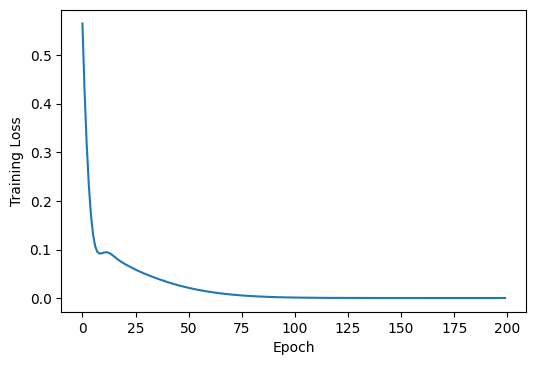

In [13]:
plt.plot(dict_losses.keys(), dict_losses.values())
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

fig = plt.gcf()
fig.set_size_inches(6,4)
fig.set_dpi(100)

plt.savefig(os.path.join(results_in_out,'loss.png'), bbox_inches='tight', facecolor="w")

In [14]:
def predict(model, loader, inverse_transform=False, scaler=None):
    preds = []
    with torch.no_grad():               # not training, so no need to calculate gradients
        for inputs, labels in loader:
            outputs = model(inputs)
            preds.append(outputs)
    preds = torch.cat(preds, axis=0).numpy()
    if inverse_transform:
        preds = scaler.inverse_transform(preds)
    return preds

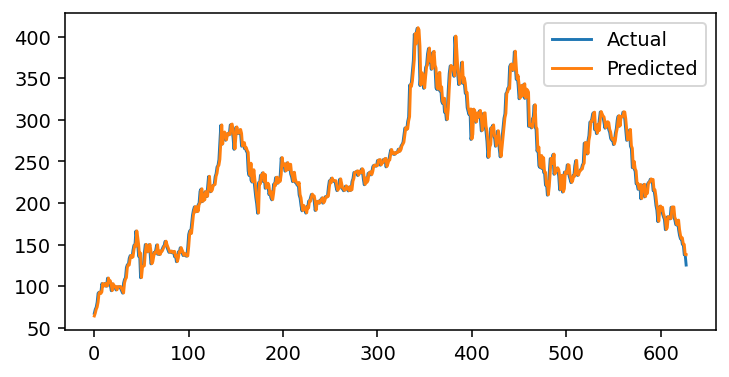

In [15]:
preds_test = predict(model, test_loader, inverse_transform=True, scaler=scaler)

actual_and_pred = pd.DataFrame(columns=['Actual','Predicted'])
actual_and_pred['Actual'] = Y_test[:,0]
actual_and_pred['Predicted'] = preds_test[:,0]

fig = plt.figure(figsize=(6,3), dpi=140)
actual_and_pred.plot(ax=plt.gca())
plt.savefig(os.path.join(results_in_out,'test.png'), bbox_inches='tight', facecolor="w")

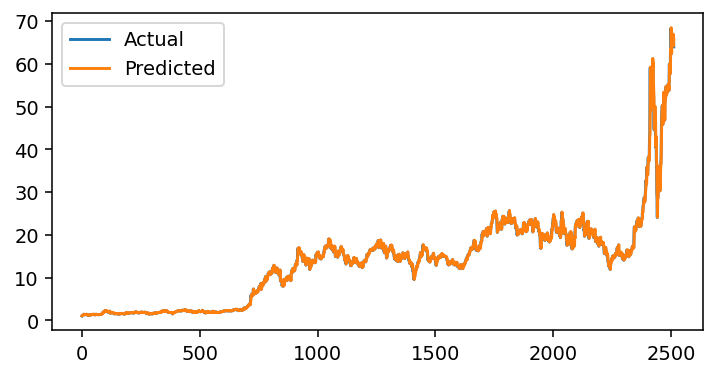

In [16]:
preds_train = predict(model, train_loader, inverse_transform=True, scaler=scaler)
train_Y_df = pd.DataFrame(columns=['Actual', 'Predicted'])
train_Y_df['Actual'] = (scaler.inverse_transform(Y_train))[:,0]
train_Y_df['Predicted'] = preds_train[:,0]

fig = plt.figure(figsize=(6,3), dpi=140)
train_Y_df.plot(ax=plt.gca())
plt.savefig(os.path.join(results_in_out,'train.png'), bbox_inches='tight', facecolor="w")
                                                                                    # facecolor: jupyter problem
                                                                                    # https://stackoverflow.com/questions/52371499